In [18]:
# ============================
# Imports
# ============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
import sqlite3

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim

plt.style.use("seaborn-v0_8")

In [26]:
# ============================
# Configuration
# ============================
start_date = "2022-05-01"
sequence_length = 30      # number of past days to look at
train_ratio = 0.7         # 80% train, 20% test
num_epochs = 200
learning_rate = 1e-3
hidden_size = 64
num_layers = 2
dropout = 0.2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [27]:
# ============================
# 1. Load NVDA from SQLite
# ============================
from pathlib import Path
import sqlite3
import pandas as pd

# Use PROJECT_ROOT if injected by papermill; otherwise fall back to parent dir
try:
    project_root = Path(PROJECT_ROOT)   # set from fastapi_app.py
except NameError:
    project_root = Path().resolve().parent   # running manually from model/

print("project_root:", project_root)

db_path = project_root / "data" / "processed" / "NVDA_proc.sqlite"

print("DB path:", db_path)
print("Exists:", db_path.exists())
if not db_path.exists():
    raise FileNotFoundError(f"Database not found at {db_path}")

conn = sqlite3.connect(str(db_path))

# List tables once (to see names)
tables = pd.read_sql(
    "SELECT name FROM sqlite_master WHERE type='table';",
    conn
)
print("Tables in DB:")
print(tables)

# TODO: set this explicitly once you know it
table_name = tables["name"].iloc[0]   # e.g. "prices" or "nvda_prices"
print("Using table:", table_name)

# Inspect columns once to see exact names
cols = pd.read_sql(f"PRAGMA table_info({table_name});", conn)
print("Columns in table:")
print(cols)

# ====== USE REAL COLUMN NAMES: Date and Close ======
df = pd.read_sql(
    f"""
    SELECT Date, Close
    FROM {table_name}
    WHERE Date >= ?
    ORDER BY Date;
    """,
    conn,
    params=(start_date,),
    parse_dates=["Date"],    # parse the Date column as datetime
)
conn.close()

# Use Date as index and keep Close as the price column
df.set_index("Date", inplace=True)    # index is now the timestamp

close_prices = df[["Close"]].dropna()
ticker = "NVDA"

print(close_prices.head())
print("Total rows:", len(close_prices))

project_root: C:\Users\soltv\Documents\GitHub\newalgotrade
DB path: C:\Users\soltv\Documents\GitHub\newalgotrade\data\processed\NVDA_proc.sqlite
Exists: True
Tables in DB:
   name
0  NVDA
Using table: NVDA
Columns in table:
   cid    name       type  notnull dflt_value  pk
0    0   Price       TEXT        0       None   0
1    1   Close       TEXT        0       None   0
2    2    High       TEXT        0       None   0
3    3     Low       TEXT        0       None   0
4    4    Open       TEXT        0       None   0
5    5  Volume       TEXT        0       None   0
6    6    Date  TIMESTAMP        0       None   0
                         Close
Date                          
2022-05-02   19.49964141845703
2022-05-03  19.568523406982422
2022-05-04   20.29927635192871
2022-05-05  18.811817169189453
2022-05-06   18.64310646057129
Total rows: 899


In [28]:
# ============================
# 2. Features & scaling
# ============================
df = close_prices.copy()          # if you haven't already

# Make sure Close is numeric
df["Close"] = pd.to_numeric(df["Close"], errors="coerce")
df = df.dropna(subset=["Close"])

# Now this works
df["log_ret"] = np.log(df["Close"]).diff()

df["log_ret"] = np.log(df["Close"]).diff()
df["vol_5"] = df["log_ret"].rolling(5).std()
df["vol_20"] = df["log_ret"].rolling(20).std()
df["ma_10"] = df["Close"].rolling(10).mean()
df["ma_30"] = df["Close"].rolling(30).mean()
df["ma_ratio"] = df["ma_10"] / df["ma_30"]

df = df.dropna()

feature_cols = ["log_ret", "vol_5", "vol_20", "ma_ratio"]
target_col = "log_ret"   # predict next-day log return

X_raw = df[feature_cols].values
y_raw = df[target_col].shift(-1).values   # next day
df = df.iloc[:-1]
X_raw = X_raw[:-1]
y_raw = y_raw[:-1]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

def create_sequences(X: np.ndarray, y: np.ndarray, window: int):
    Xs, ys = [], []
    for i in range(len(X) - window):
        Xs.append(X[i : i + window])
        ys.append(y[i + window])
    return np.array(Xs), np.array(ys)

X_all, y_all = create_sequences(X_scaled, y_raw, sequence_length)
print("X_all shape:", X_all.shape)   # (num_samples, seq_len, n_features)
print("y_all shape:", y_all.shape)

n_samples, seq_len, n_features = X_all.shape


# ============================
# 3. Sequence creation
# ============================
def create_sequences(series: np.ndarray, window: int):
    """
    series: shape (N, 1)
    window: number of time steps in the input sequence

    Returns:
        X: shape (N - window, window, 1)
        y: shape (N - window, 1)
    """
    X, y = [], []
    for i in range(len(series) - window):
        x_i = series[i : i + window]      # window x 1
        y_i = series[i + window]          # 1 x 1
        X.append(x_i)
        Y = y_i
        y.append(y_i)
    return np.array(X), np.array(y)

X_all, y_all = create_sequences(close_scaled, sequence_length)
print("X_all shape:", X_all.shape)   # (num_samples, seq_len, 1)
print("y_all shape:", y_all.shape)   # (num_samples, 1)

# ============================
# ============================
# 4. Train / val / test split
# ============================
train_ratio = 0.7
val_ratio = 0.15

train_end = int(n_samples * train_ratio)
val_end   = int(n_samples * (train_ratio + val_ratio))

X_train_np, y_train_np = X_all[:train_end], y_all[:train_end]
X_val_np,   y_val_np   = X_all[train_end:val_end], y_all[train_end:val_end]
X_test_np,  y_test_np  = X_all[val_end:], y_all[val_end:]

X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(-1).to(device)
X_val   = torch.tensor(X_val_np,   dtype=torch.float32).to(device)
y_val   = torch.tensor(y_val_np,   dtype=torch.float32).unsqueeze(-1).to(device)
X_test  = torch.tensor(X_test_np,  dtype=torch.float32).to(device)
y_test  = torch.tensor(y_test_np,  dtype=torch.float32).unsqueeze(-1).to(device)

print("Train samples:", X_train.shape[0])
print("Val samples  :", X_val.shape[0])
print("Test samples :", X_test.shape[0])


# ============================
# 5. Tensors
# ============================
X_train = torch.from_numpy(X_train_np).float().to(device)
y_train = torch.from_numpy(y_train_np).float().to(device)
X_test  = torch.from_numpy(X_test_np).float().to(device)
y_test  = torch.from_numpy(y_test_np).float().to(device)

print("Train samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])

# ============================

X_all shape: (839, 30, 4)
y_all shape: (839,)
X_all shape: (1877, 30, 1)
y_all shape: (1877, 1)
Train samples: 587
Val samples  : 126
Test samples : 1164
Train samples: 587
Test samples: 1164


In [29]:
# ============================
# 6. LSTM model (returns)
# ============================
class ReturnLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, x):
        out, _ = self.lstm(x)          # (batch, seq_len, hidden_size)
        last_out = out[:, -1, :]       # (batch, hidden_size)
        return self.fc(last_out)       # (batch, 1)


# Infer number of features from training data
n_features = X_train.shape[2]

# Ensure y_* tensors are (N, 1)
if y_train.ndim == 1:
    y_train = y_train.view(-1, 1)
if y_val.ndim == 1:
    y_val = y_val.view(-1, 1)
if y_test.ndim == 1:
    y_test = y_test.view(-1, 1)

model = ReturnLSTM(
    input_size=n_features,
    hidden_size=64,
    num_layers=2,
    dropout=0.3,
).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# ============================
# 7. Training loop with early stopping
# ============================
num_epochs = 200
patience = 20
best_val = float("inf")
best_state = None
no_improve = 0

for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()
    preds = model(X_train)
    loss = criterion(preds, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_val)
        val_loss = criterion(val_preds, y_val).item()

    if val_loss < best_val - 1e-5:
        best_val = val_loss
        best_state = model.state_dict()
        no_improve = 0
    else:
        no_improve += 1

    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d} | train={loss.item():.6f} | val={val_loss:.6f}")

    if no_improve >= patience:
        print(f"Early stopping at epoch {epoch}, best_val={best_val:.6f}")
        break

if best_state is not None:
    model.load_state_dict(best_state)

# ============================
# 8. Evaluation (returns + direction)
# ============================
model.eval()
with torch.no_grad():
    train_pred = model(X_train).cpu().numpy().flatten()
    val_pred   = model(X_val).cpu().numpy().flatten()
    test_pred  = model(X_test).cpu().numpy().flatten()

y_train_true = y_train.cpu().numpy().flatten()
y_val_true   = y_val.cpu().numpy().flatten()
y_test_true  = y_test.cpu().numpy().flatten()

def rmse(a, b):
    return np.sqrt(((a - b) ** 2).mean())

print(f"Train RMSE (ret): {rmse(y_train_true, train_pred):.6f}")
print(f"Val   RMSE (ret): {rmse(y_val_true,   val_pred):.6f}")
print(f"Test  RMSE (ret): {rmse(y_test_true,  test_pred):.6f}")

# Directional accuracy
test_dir_acc = (np.sign(test_pred) == np.sign(y_test_true)).mean() * 100
print(f"Test directional accuracy: {test_dir_acc:.2f}%")

c:\Users\soltv\AppData\Local\Programs\Python\Python314\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([126, 1, 1])) that is different to the input size (torch.Size([126, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch   1 | train=0.762593 | val=0.513436
Epoch  20 | train=0.002610 | val=0.088015
Epoch  40 | train=0.007476 | val=0.006045
Early stopping at epoch 54, best_val=0.000179
Train RMSE (ret): 0.050759
Val   RMSE (ret): 0.151504
Test  RMSE (ret): 1.340256
Test directional accuracy: 51.72%


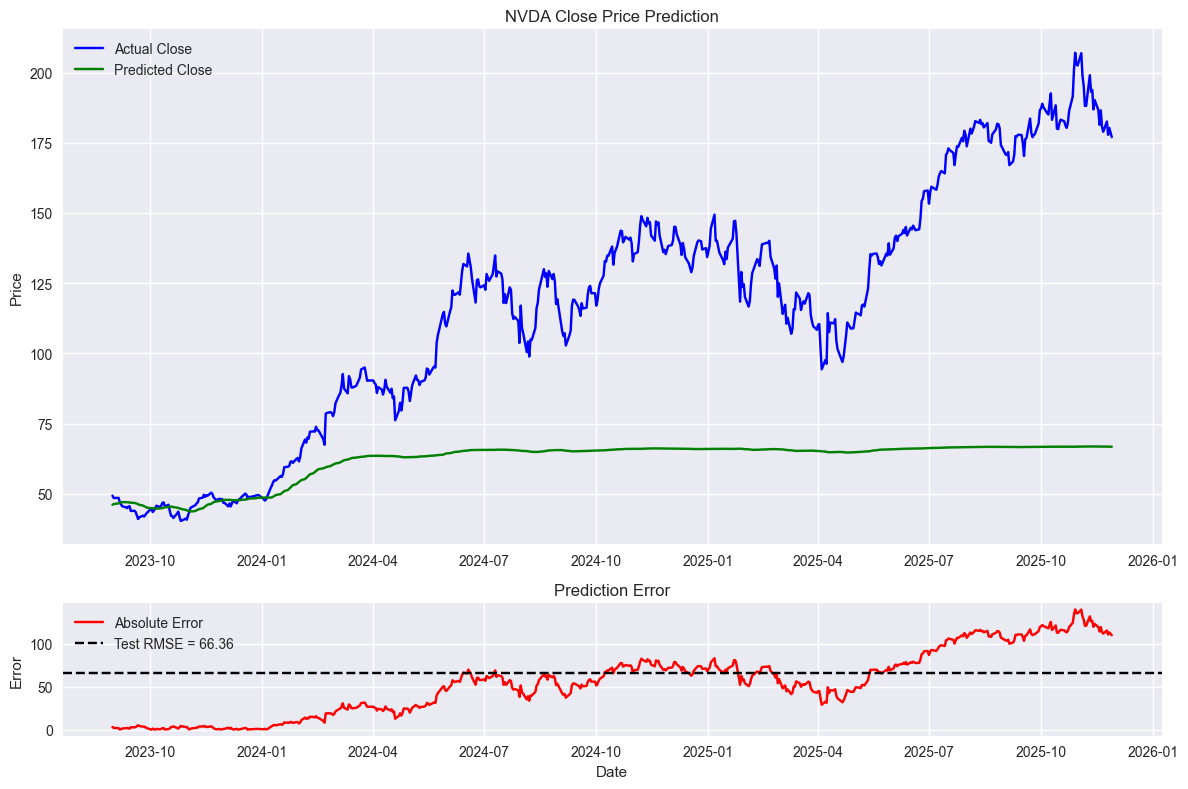

In [30]:
# ============================
# 9. Plot predictions (test)
# ============================
test_start_index = len(close_prices) - len(y_test_price)
test_dates = close_prices.index[test_start_index:]

fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(4, 1)

ax1 = fig.add_subplot(gs[:3, 0])
ax1.plot(test_dates, y_test_price.flatten(), color="blue", label="Actual Close")
ax1.plot(test_dates, test_pred_price.flatten(), color="green", label="Predicted Close")
ax1.set_title(f"{ticker} Close Price Prediction")
ax1.set_ylabel("Price")
ax1.legend()

ax2 = fig.add_subplot(gs[3, 0], sharex=ax1)
abs_error = np.abs(y_test_price - test_pred_price).flatten()
ax2.plot(test_dates, abs_error, color="red", label="Absolute Error")
ax2.axhline(test_rmse, color="black", linestyle="--",
            label=f"Test RMSE = {test_rmse:.2f}")
ax2.set_xlabel("Date")
ax2.set_ylabel("Error")
ax2.set_title("Prediction Error")
ax2.legend()

plt.tight_layout()
plt.show()

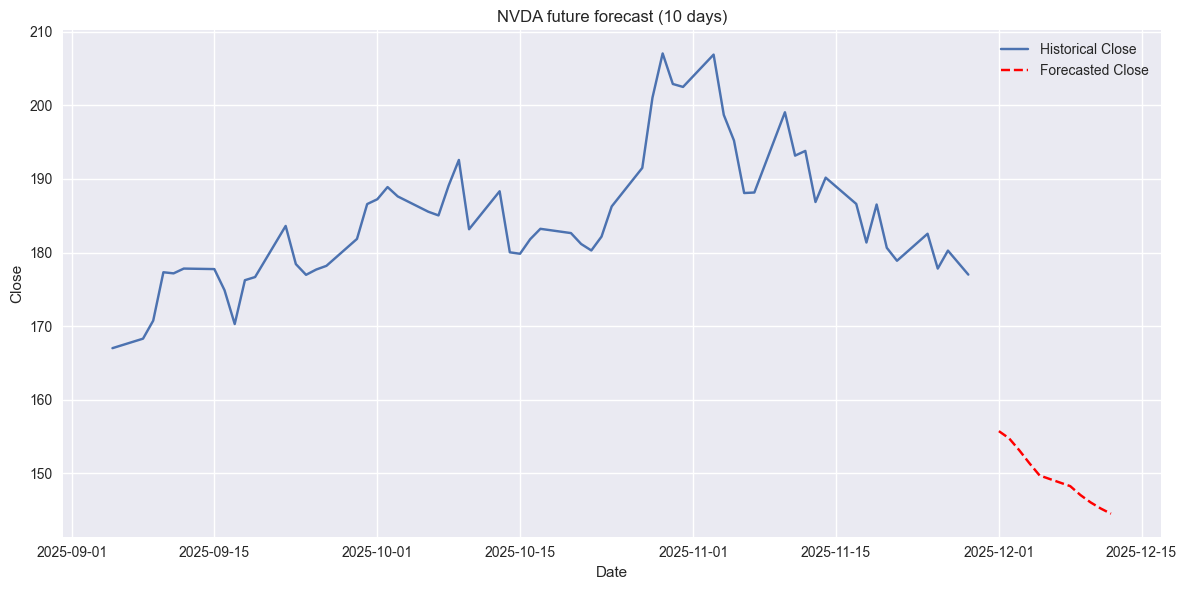

In [9]:
# ============================
# 10. Future forecasting (fixed)
# ============================
def forecast_future(model, scaler, close_scaled, steps=10, sequence_length=30, device="cpu"):
    model.eval()
    last_window = close_scaled[-sequence_length:]      # (seq_len, 1)
    window = torch.from_numpy(last_window).float().unsqueeze(0).to(device)
    future_scaled = []

    with torch.no_grad():
        for _ in range(steps):
            next_scaled = model(window)                # (1, 1)
            future_scaled.append(next_scaled.cpu().numpy())
            next_step = next_scaled.unsqueeze(1)       # (1, 1, 1)
            window = torch.cat([window[:, 1:, :], next_step], dim=1)

    future_scaled_arr = np.vstack(future_scaled)       # (steps, 1)
    future_closes = scaler.inverse_transform(future_scaled_arr)
    return future_closes


# 1) Make sure Close is numeric (y-axis must be numbers, not dates/strings)
close_prices["Close"] = pd.to_numeric(close_prices["Close"], errors="coerce")
close_prices = close_prices.dropna(subset=["Close"])

# 2) DO NOT create a new scaler; reuse the one from training
#    'scaler' and 'close_scaled' come from earlier in the notebook.

future_days = 10
future_closes = forecast_future(
    model=model,
    scaler=scaler,
    close_scaled=close_scaled,
    steps=future_days,
    sequence_length=sequence_length,
    device=device,
)

last_date = close_prices.index[-1]
future_index = pd.bdate_range(start=last_date + pd.Timedelta(days=1),
                              periods=future_days)

# 3) Plot only recent history for readability
history_window = 60  # last 60 days
history_tail = close_prices.tail(history_window)

plt.figure(figsize=(12, 6))
plt.plot(history_tail.index, history_tail["Close"], label="Historical Close")
plt.plot(future_index, future_closes.flatten(), "r--", label="Forecasted Close")
plt.title(f"{ticker} future forecast ({future_days} days)")
plt.xlabel("Date")
plt.ylabel("Close")
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# ============================
# 11. Signals from 10-day forecast
# ============================

# Put forecast into a DataFrame
df_future = pd.DataFrame(
    {"Pred_Close": future_closes.flatten()},
    index=future_index,
)
df_future.index.name = "Date"

# Ensure numeric dtype
df_future["Pred_Close"] = df_future["Pred_Close"].astype(float)
last_actual_close = float(close_prices["Close"].iloc[-1])

# Compute predicted 1-day returns
pred_returns = []
for i, p in enumerate(df_future["Pred_Close"].values):
    p = float(p)
    if i == 0:
        prev_price = last_actual_close      # compare first forecast to last actual close
    else:
        prev_price = float(df_future["Pred_Close"].values[i - 1])
    r = (p - prev_price) / prev_price
    pred_returns.append(r)

df_future["pred_ret"] = pred_returns

# Apply your rule:
# > +3%  -> buy (1)
# < -2%  -> sell (-1)
# else   -> hold (0)
df_future["signal"] = 0
df_future.loc[df_future["pred_ret"] >  0.03, "signal"] = 1
df_future.loc[df_future["pred_ret"] < -0.02, "signal"] = -1

print("Forecasts and signals for next 10 days:")
print(df_future)

Forecasts and signals for next 10 days:
            Pred_Close  pred_ret  signal
Date                                    
2025-12-01  155.740936 -0.120108      -1
2025-12-02  154.768021 -0.006247       0
2025-12-03  153.145920 -0.010481       0
2025-12-04  151.376755 -0.011552       0
2025-12-05  149.716690 -0.010966       0
2025-12-08  148.274490 -0.009633       0
2025-12-09  147.066818 -0.008145       0
2025-12-10  146.066116 -0.006804       0
2025-12-11  145.232147 -0.005710       0
2025-12-12  144.527649 -0.004851       0


In [11]:
# X_all, y_all are from create_sequences(close_scaled, sequence_length)
# model, scaler, close_prices already exist

model.eval()
with torch.no_grad():
    all_pred_scaled = model(torch.from_numpy(X_all).float().to(device)).cpu().numpy()

all_pred_close = scaler.inverse_transform(all_pred_scaled)      # (N, 1)
all_true_close = scaler.inverse_transform(y_all)                # (N, 1)

# Dates aligned with y_all: start at sequence_length
signal_dates = close_prices.index[sequence_length:]

signals = pd.DataFrame(index=signal_dates)
signals["Close"] = all_true_close.flatten()        # actual next-day close
signals["Pred_Close"] = all_pred_close.flatten()

# Example rule: if predicted return > 3% -> long, < -2% -> short, else flat
signals["pred_ret"] = (signals["Pred_Close"] - signals["Close"].shift(1)) / signals["Close"].shift(1)
signals["signal"] = 0
signals.loc[signals["pred_ret"] >  0.02, "signal"] = 1
signals.loc[signals["pred_ret"] < -0.02, "signal"] = -1

signals.dropna(inplace=True)
print(signals.head())
from pathlib import Path

project_root = Path().resolve().parent      # model -> NEWALGOTRADE
out_path = project_root / "data" / "signals_nvda_lstm_hist.csv"

signals.to_csv(out_path)
print("Saved historical signals to:", out_path)


                 Close  Pred_Close  pred_ret  signal
Date                                                
2024-06-14  131.830933  130.498123  0.007227       0
2024-06-17  130.931259  133.282913  0.011014       0
2024-06-18  135.529541  133.399139  0.018849       0
2024-06-20  130.731339  133.884415 -0.012139       0
2024-06-21  126.522888  132.461563  0.013235       0
Saved historical signals to: C:\Users\soltv\Documents\GitHub\newalgotrade\data\signals_nvda_lstm_hist.csv


In [12]:
# Direction accuracy (up/down)
actual_diff = np.diff(y_test_price.flatten())
pred_diff   = np.diff(test_pred_price.flatten())
actual_dir = np.sign(actual_diff)
pred_dir   = np.sign(pred_diff)
direction_accuracy = np.mean(actual_dir == pred_dir) * 100
print(f"Direction accuracy (up/down): {direction_accuracy:.2f}%")

Direction accuracy (up/down): 48.18%
